- 사기거래탐지

# EDA

### 데이터 불러오기

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [188]:
card_df = pd.read_csv('../data/ftd/cards_data.csv')
trans_df = pd.read_csv('../data/ftd/transactions_data.csv')
user_df = pd.read_csv('../data/ftd/users_data.csv')
mcc_df = pd.read_json('../data/ftd/mcc_codes.json', orient='index').rename({0:'category'}, axis=1)
fraud_df = pd.read_json('../data/ftd/train_fraud_labels.json')

### 데이터별 컬럼 의미

In [328]:
# card_df

- **id**: 카드 id 
- **client**: 고객 id
- **card_brand**: 카드사
- **card_type**: 카드 종류(신용/체크)
- **card_number**: 카드번호
- **expires**: 카드 만료기간
- **cvv**: 카드 인증코드
- **has_chip**: 카드 IC칩 보유 여부(IC칩 있을 시 카드 도용/복제에 상대적으로 안전)
- **num_cards_issued**: 문제 발생 횟수??
- **credit_limit**: 신용 한도
- **acct_open_date**: 계좌 개설일
- **year_pin_last_changed**: 카드 pin번호 최근 변경연도
- **card_on_dark_web**: 다크웹 사용?? => No만 존재 => 제거 가능

In [234]:
# trans_df

- **id**: 거래식별번호
- **date**: 거래일자
- **client_id**: 고객id
- **card_id**: 카드id
- **amount**: 거래금액 => 음수 데이터 존재
- **use_chip**: 카드 결제 방식
    - Swipe Transaction: 마그네틱 카드로 긁어서 결제
    - Chip Transaction: ic칩 카드로 결제
    - Online Transaction: 온라인 결제
- **merchant_id**: 매장id
- **merchant_city**: 매장 위치(시)
- **merchant_state**: 매장 위치(주)
- **zip**: 매장 우편번호
- **mcc**: 매장 분류코드
- **errors**: 거래 성공 여부(결제 오류 시 오류 원인이 적혀있음)

In [321]:
# user_df

- **id**: 고객id
- **current_age**: 현재 나이
- **retirement_age**: 퇴직 연령
- **birth_year**: 출생연도
- **gender**: 성별
- **address**: 주소
- **latitude**: 위도
- **longitude**: 경도
- **per_capita_income**: 1인당 소득 (전체 소득 / 인구 수)
- **yearly_income**: 연봉
- **total_debt**: 채무액
- **credit_score**: 신용점수
- **num_credit_cards**: 보유 중인 신용카드 수

In [324]:
mcc_df.reset_index()

,index,category
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees
...,...,...
104,7549,Towing Services
105,5941,Sporting Goods Stores
106,5722,Household Appliance Stores
107,3009,Fabricated Structural Metal Products


- mcc별 상점 종류

In [326]:
fraud_df.reset_index()

,index,target
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No
...,...,...
8914958,14064699,No
8914959,7676538,No
8914960,15131030,No
8914961,17244732,No


- 거래 id별 정상거래/사기거래 여부

### 데이터 살펴보기

In [200]:
# trans_df의 mcc, mcc_df의 index 기준으로 merge
trans_df = trans_df.merge(mcc_df.reset_index(), left_on='mcc', right_on='index', how='left')

# mcc 정보 제거
trans_df.drop(['mcc', 'index'], axis=1, inplace=True)

# category 이름 변경
trans_df.rename({'category': 'merchant_cat'}, axis=1, inplace=True)

# amount $제거, float으로 자료형 변환
trans_df = trans_df.merge(fraud_df.reset_index(), left_on='id', right_on='index')
trans_df.drop('index', axis=1, inplace=True)
# trans_df['amount'] = pd.to_numeric(trans_df['amount'].str.split('$', expand=True)[1])

In [202]:
# trans_df와 user_df merge
trans_df = trans_df.merge(user_df, left_on='client_id', right_on='id', how='left')
trans_df = trans_df.rename({'id_x':'id'}, axis=1)
trans_df.drop('id_y', axis=1, inplace=True)

In [206]:
# trans_df와 card_df merge
trans_df = trans_df.merge(card_df, left_on='card_id', right_on='id')
trans_df = trans_df.rename({'id_x':'id', 'client_id_x': 'client_id'}, axis=1)
trans_df.drop(['id_y', 'client_id_y'], axis=1, inplace=True)

In [327]:
trans_df

,date,amount,use_chip,merchant_city,merchant_state,errors,merchant_cat,target,current_age,gender,address,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,age_band,yi_cat
0,2010-01-01 00:01:00,-77.00,Swipe Transaction,Beulah,ND,NaN,food,0,30,Female,594 Mountain View Street,$23679,48277,$110153,740,4,Mastercard,Debit (Prepaid),YES,2,$55,05/2008,2008,3,6
1,2010-01-01 00:02:00,14.57,Swipe Transaction,Bettendorf,IA,NaN,retail,0,48,Male,604 Pine Street,$18076,36853,$112139,834,5,Mastercard,Credit,YES,1,$9100,09/2005,2015,4,3
2,2010-01-01 00:02:00,80.00,Swipe Transaction,Vista,CA,NaN,service,0,49,Male,2379 Forest Lane,$16894,34449,$36540,686,3,Mastercard,Debit,YES,1,$14802,01/2006,2008,4,2
3,2010-01-01 00:06:00,46.41,Swipe Transaction,Harwood,MD,NaN,food,0,51,Male,166 River Drive,$33529,68362,$96182,711,2,Visa,Debit,YES,1,$19113,07/2009,2014,5,8
4,2010-01-01 00:07:00,4.81,Swipe Transaction,Bronx,NY,NaN,retail,0,47,Female,14780 Plum Lane,$25537,52065,$98613,828,5,Mastercard,Debit (Prepaid),YES,1,$89,01/2008,2015,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8914958,2019-10-31 23:54:00,12.93,Chip Transaction,Cosby,TN,NaN,retail,0,37,Male,95873 Madison Boulevard,$11755,23967,$3880,722,4,Visa,Debit,YES,1,$8333,10/2003,2007,3,0
8914959,2019-10-31 23:54:00,67.01,Chip Transaction,Williamson,GA,NaN,food,0,74,Female,528 Lake Drive,$22545,23011,$30510,721,3,Visa,Debit,YES,2,$24617,07/2004,2006,7,0
8914960,2019-10-31 23:56:00,1.11,Chip Transaction,West Covina,CA,NaN,food,0,81,Female,766 Third Drive,$22681,33483,$196,698,5,Mastercard,Debit,YES,1,$26743,03/2019,2019,7,2
8914961,2019-10-31 23:56:00,12.80,Online Transaction,ONLINE,NaN,NaN,retail,0,62,Male,6076 Bayview Boulevard,$9995,20377,$12092,789,4,Mastercard,Debit,YES,1,$5141,03/2004,2012,6,0


In [236]:
# trans_df.isna().sum()

#### trans_df

In [237]:
# trans_df.info()

- date는 datetime으로 바꾸는게 좋아보임
- amount 음수인 경우 확인 필요

In [139]:
# 결측치 백분율
np.round((trans_df.isna().sum() / trans_df.shape[0]) * 100, 2)

id                 0.00
date               0.00
client_id          0.00
card_id            0.00
amount             0.00
use_chip           0.00
merchant_id        0.00
merchant_city      0.00
merchant_state    11.75
zip               12.42
mcc                0.00
errors            98.41
dtype: float64

In [238]:
# display(trans_df.loc[trans_df['target']=='Yes', 'merchant_state'].value_counts().head(10))
# print(f"\n=> merchant_state=='Italy'의 사기거래 비율: {np.round(trans_df.loc[trans_df['target']=='Yes', 'merchant_state'].value_counts()[0]/trans_df.loc[trans_df['merchant_state']=='Italy'].shape[0], 2)}")

- errors의 결측치: 결제 성공 의미 => NaN대신 다른 값으로 변환 필요해 보임
- merchant_state => Italy 사기거래 백분율 65% => 단순 우연?
- zip => 별 의미 없는 데이터

#### 생각해볼만한 것

- card_brand와 사기거래 관련성
- card_type과 사기거래 관련성
- has_chip과 사기거래 관련성
- credit_limit과 사기거래 관련성

- date와 사기거래 관련성
- amount와 사기거래 관련성
- use_chip과 사기거래 관련성
- merchant_state와 사기거래 관련성
- category와 사기거래 관련성

- current_age와 사기거래 관련성
- gender과 사기거래 관련성
- latitude, longitude와 사기거래 관련성
- yearly_income와 사기거래 관련성
- credit_score와 사기거래 관련성
- num_credit_cards와 사기거래 관련성

### 중복값 확인

In [239]:
# mcc_df[mcc_df.duplicated(keep=False)]

- trans_df와 합치면 상관없음

### 시각화

##### amount와 target

In [257]:
# target 수치형 데이터로 변환
trans_df['target'] = trans_df['target'].replace({'No': 0, 'Yes': 1})

In [240]:
# f, ax = plt.subplots(1, 2, figsize=(12, 5))
# trans_df.loc[trans_df['target']==1, 'amount'].hist(bins=50, ax=ax[0])
# ax[0].set_title('fraud amount')
# trans_df.loc[trans_df['target']==0, 'amount'].hist(bins=50, ax=ax[1])
# ax[1].set_title('normal amount')
# plt.show()

In [241]:
# print(trans_df.loc[trans_df['target']==1, 'amount'].describe(), '\n')
# print(trans_df.loc[trans_df['target']==0, 'amount'].describe())

In [242]:
# trans_df[['amount', 'target']].corr()

- amount과 사기거래는 큰 관계가 없는 것으로 보임

##### date와 target

In [243]:
trans_df['date'] = pd.to_datetime(trans_df['date'])

In [244]:
# f, ax = plt.subplots(1, 2, figsize=(12, 5))
# trans_df['year'] = trans_df['date'].dt.year
# trans_df.groupby('year').agg({'target':'mean'}).plot.bar(ax=ax[0])
# ax[0].set_title('Fraud Rate by Year')
# trans_df['month'] = trans_df['date'].dt.month
# trans_df.groupby('month').agg({'target':'mean'}).plot.bar(ax=ax[1])
# ax[1].set_title('Fraud Rate by Month')
# plt.show()

- 2011, 2017은 사기거래 비율이 적으며, 2010이 가장 높음

##### use_chip과 target

In [245]:
# f, ax = plt.subplots(1, 2, figsize=(12, 5))
# trans_df.groupby('use_chip').agg({'target':'count'}).plot.bar(ax=ax[0])
# ax[0].set_title('Fraud Count by use_chip')
# trans_df.groupby('use_chip').agg({'target':'mean'}).plot.bar(ax=ax[1])
# ax[1].set_title('Fraud Rate by use_chip')
# plt.show()

- 사기거래 수는 마그네틱 카드가 가장 많음
- 온라인 거래의 사기거래 비율이 가장 높음

In [246]:
# trans_df['merchant_state'].nunique()

In [247]:
# trans_df['merchant_state'].value_counts().tail(45)

In [248]:
# trans_df['merchant_cat'].nunique()

In [249]:
# trans_df.loc[trans_df['target']==1, 'merchant_id'].value_counts()

In [250]:
# user_df

In [251]:
# trans_df.loc[trans_df['target']==1, 'client_id'].value_counts()

# Feature Engineering

- card_df
    - card_on_dark_web 제거 가능
- trans_df
    - errors 거래 성공여부 확인하려면 성공을 NaN에서 다른 값으로 대체 필요
    - date 날짜 정보 활용하려면 datetime으로 형변환 필요
    - amount 음수인 경우 확인 필요
    - zip 제거 가능
    - Italy 사기거래 비율 높은 이유 확인 필요

- user 구분
- mcc 범주화

In [231]:
# 불필요 컬럼 제거
trans_df.drop(['zip', 'card_on_dark_web'], axis=1, inplace=True)
trans_df.drop(['id', 'client_id', 'card_id', 'merchant_id', 'card_number'], axis=1, inplace=True) # merge 끝났으므로 단순 식별용 컬럼 제거
trans_df.drop(['retirement_age', 'birth_year', 'birth_month', 'latitude', 'longitude', 'expires', 'cvv'], axis=1, inplace=True)

In [216]:
# mcc 범주화
food = ['Eating Places and Restaurants', 'Fast Food Restaurants', 'Drinking Places (Alcoholic Beverages)', 'Grocery Stores, Supermarkets', 
              'Miscellaneous Food Stores', 'Package Stores, Beer, Wine, Liquor', 'Wholesale Clubs', 'Discount Stores']

medical = ['Medical Services', 'Doctors, Physicians', 'Dentists and Orthodontists', 'Chiropractors', 'Podiatrists',
                    'Optometrists, Optical Goods and Eyeglasses', 'Hospitals', 'Drug Stores and Pharmacies']

transport = ['Service Stations', 'Automotive Service Shops', 'Automotive Body Repair Shops', 'Automotive Parts and Accessories Stores',
                       'Taxicabs and Limousines', 'Bus Lines', 'Passenger Railways', 'Railroad Passenger Transport', 'Railroad Freight',
                       'Motor Freight Carriers and Trucking', 'Airlines', 'Cruise Lines', 'Lodging - Hotels, Motels, Resorts',
                       'Local and Suburban Commuter Transportation']

service = ['Laundry Services', 'Car Washes', 'Towing Services', 'Cleaning and Maintenance Services', 'Tax Preparation Services',
                   'Accounting, Auditing, and Bookkeeping Services', 'Legal Services and Attorneys', 'Detective Agencies, Security Services', 'Money Transfer',
                   'Insurance Sales, Underwriting', 'Travel Agencies']

retail = ['Department Stores', 'Family Clothing Stores', "Women's Ready-To-Wear Stores", 'Shoe Stores', 'Sports Apparel, Riding Apparel Stores',
              'Sporting Goods Stores', 'Leather Goods', 'Precious Stones and Metals', 'Antique Shops', 'Music Stores - Musical Instruments',
              'Artist Supply Stores, Craft Shops', 'Book Stores', 'Books, Periodicals, Newspapers', 'Electronics Stores',
              'Computers, Computer Peripheral Equipment', 'Digital Goods - Media, Books, Apps', 'Digital Goods - Games', 'Cosmetic Stores',
              'Beauty and Barber Shops', 'Gift, Card, Novelty Stores', 'Miscellaneous Home Furnishing Stores', 
              'Furniture, Home Furnishings, and Equipment Stores', 'Upholstery and Drapery Stores', 'Lighting, Fixtures, Electrical Supplies',
              'Floor Covering Stores', 'Lawn and Garden Supply Stores', 'Gardening Supplies', 'Hardware Stores', 'Household Appliance Stores',
              'Florists Supplies, Nursery Stock and Flowers', 'Non-Precious Metal Services']

industry = ['Lumber and Building Materials', 'Brick, Stone, and Related Materials', 'Industrial Equipment and Supplies',
                    'Tools, Parts, Supplies Manufacturing', 'Heating, Plumbing, Air Conditioning Contractors', 'Fabricated Structural Metal Products',
                    'Steel Products Manufacturing', 'Steelworks', 'Ironwork', 'Welding Repair', 'Electroplating, Plating, Polishing Services',
                    'Heat Treating Metal Services', 'Bolt, Nut, Screw, Rivet Manufacturing', 'Coated and Laminated Products', 'Non-Ferrous Metal Foundries',
                    'Steel Drums and Barrels', 'Miscellaneous Metal Fabrication', 'Miscellaneous Metals', 'Miscellaneous Fabricated Metal Products',
                    'Miscellaneous Metalwork', 'Pottery and Ceramics', 'Semiconductors and Related Devices', 'Ship Chandlers',
                    'Utilities - Electric, Gas, Water, Sanitary', 'Telecommunication Services', 'Computer Network Services', 
                    'Cable, Satellite, and Other Pay Television Services', 'Postal Services - Government Only', 'Tolls and Bridge Fees', 
                    'Amusement Parks, Carnivals, Circuses', 'Motion Picture Theaters', 'Theatrical Producers', 'Recreational Sports, Clubs', 
                    'Athletic Fields, Commercial Sports', 'Betting (including Lottery Tickets, Casinos)', 'Miscellaneous Machinery and Parts Manufacturing']

In [226]:
trans_df.loc[trans_df['merchant_cat'].isin(food), 'merchant_cat'] = 'food'
trans_df.loc[trans_df['merchant_cat'].isin(medical), 'merchant_cat'] = 'medical'
trans_df.loc[trans_df['merchant_cat'].isin(transport), 'merchant_cat'] = 'transport'
trans_df.loc[trans_df['merchant_cat'].isin(service), 'merchant_cat'] = 'service'
trans_df.loc[trans_df['merchant_cat'].isin(retail), 'merchant_cat'] = 'retail'
trans_df.loc[trans_df['merchant_cat'].isin(industry), 'merchant_cat'] = 'industry'

In [252]:
trans_df

,date,amount,use_chip,merchant_city,merchant_state,errors,merchant_cat,target,current_age,gender,address,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,2010-01-01 00:01:00,-77.00,Swipe Transaction,Beulah,ND,NaN,food,No,30,Female,594 Mountain View Street,$23679,$48277,$110153,740,4,Mastercard,Debit (Prepaid),YES,2,$55,05/2008,2008
1,2010-01-01 00:02:00,14.57,Swipe Transaction,Bettendorf,IA,NaN,retail,No,48,Male,604 Pine Street,$18076,$36853,$112139,834,5,Mastercard,Credit,YES,1,$9100,09/2005,2015
2,2010-01-01 00:02:00,80.00,Swipe Transaction,Vista,CA,NaN,service,No,49,Male,2379 Forest Lane,$16894,$34449,$36540,686,3,Mastercard,Debit,YES,1,$14802,01/2006,2008
3,2010-01-01 00:06:00,46.41,Swipe Transaction,Harwood,MD,NaN,food,No,51,Male,166 River Drive,$33529,$68362,$96182,711,2,Visa,Debit,YES,1,$19113,07/2009,2014
4,2010-01-01 00:07:00,4.81,Swipe Transaction,Bronx,NY,NaN,retail,No,47,Female,14780 Plum Lane,$25537,$52065,$98613,828,5,Mastercard,Debit (Prepaid),YES,1,$89,01/2008,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8914958,2019-10-31 23:54:00,12.93,Chip Transaction,Cosby,TN,NaN,retail,No,37,Male,95873 Madison Boulevard,$11755,$23967,$3880,722,4,Visa,Debit,YES,1,$8333,10/2003,2007
8914959,2019-10-31 23:54:00,67.01,Chip Transaction,Williamson,GA,NaN,food,No,74,Female,528 Lake Drive,$22545,$23011,$30510,721,3,Visa,Debit,YES,2,$24617,07/2004,2006
8914960,2019-10-31 23:56:00,1.11,Chip Transaction,West Covina,CA,NaN,food,No,81,Female,766 Third Drive,$22681,$33483,$196,698,5,Mastercard,Debit,YES,1,$26743,03/2019,2019
8914961,2019-10-31 23:56:00,12.80,Online Transaction,ONLINE,NaN,NaN,retail,No,62,Male,6076 Bayview Boulevard,$9995,$20377,$12092,789,4,Mastercard,Debit,YES,1,$5141,03/2004,2012


In [318]:
trans_df['errors'].unique()

array([nan, 'Bad Expiration', 'Bad Card Number', 'Insufficient Balance',
       'Bad PIN', 'Technical Glitch', 'Bad CVV',
       'Insufficient Balance,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad Zipcode',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration', 'Bad PIN,Technical Glitch',
       'Bad Card Number,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Technical Glitch', 'Bad CVV,Insufficient Balance',
       'Bad Card Number,Technical Glitch',
       'Bad Zipcode,Insufficient Balance',
       'Bad Card Number,Bad Expiration,Insufficient Balance',
       'Bad Expiration,Bad CVV', 'Bad Zipcode,Technical Glitch'],
      dtype=object)

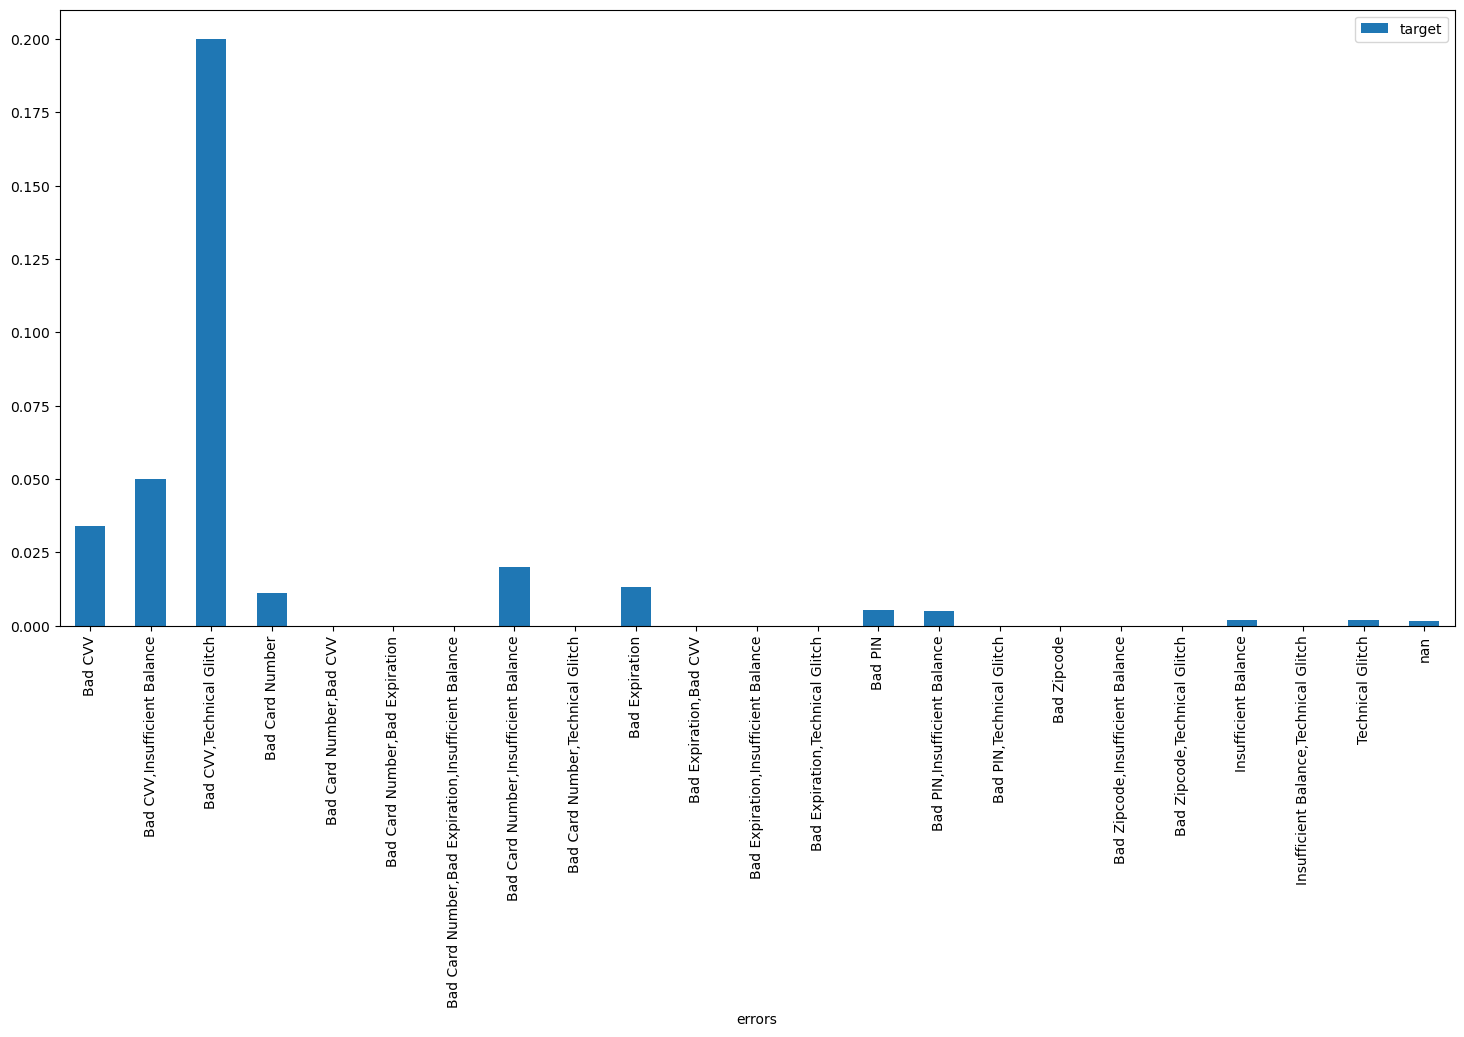

In [264]:
# errors 와 target
trans_df.groupby('errors', dropna=False).agg({'target':'mean'}).plot.bar(figsize=(18, 8))
plt.show()

- errors는 결제 성공 여부로, 이는 우리가 예측하고자 하는 사기거래일 것 같은지를 판단하는데 필요 없는 컬럼임
- 제거 필요

In [276]:
def age_band(x):
    if x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

In [278]:
trans_df['age_band'] = trans_df['current_age'].map(age_band)

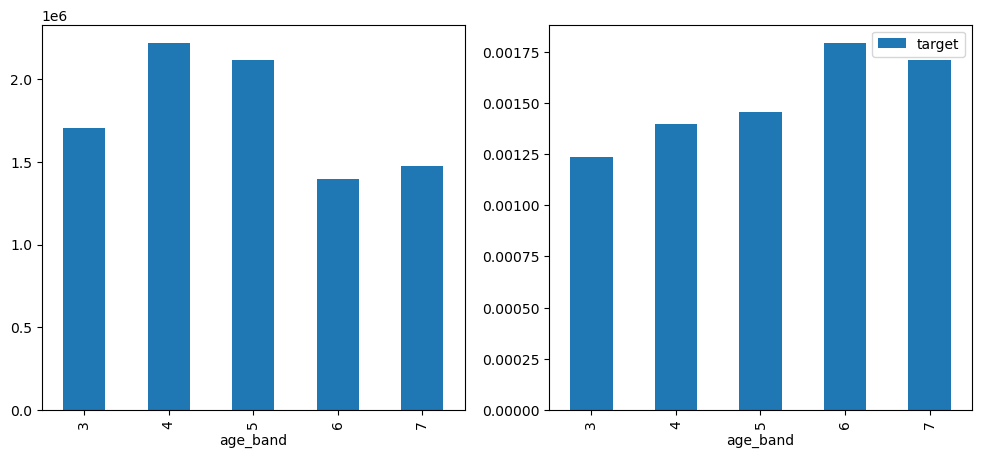

In [283]:
# age_band(current_age)와 target 비교
f, ax = plt.subplots(1, 2, figsize=(12, 5))
trans_df['age_band'].value_counts().sort_index().plot.bar(ax=ax[0])
trans_df.groupby('age_band').agg({'target': 'mean'}).plot.bar(ax=ax[1])
plt.show()

- 나이가 많을수록 사기거래 비율이 높아지긴 하나 유의미한 차이로 보기는 힘들어보임

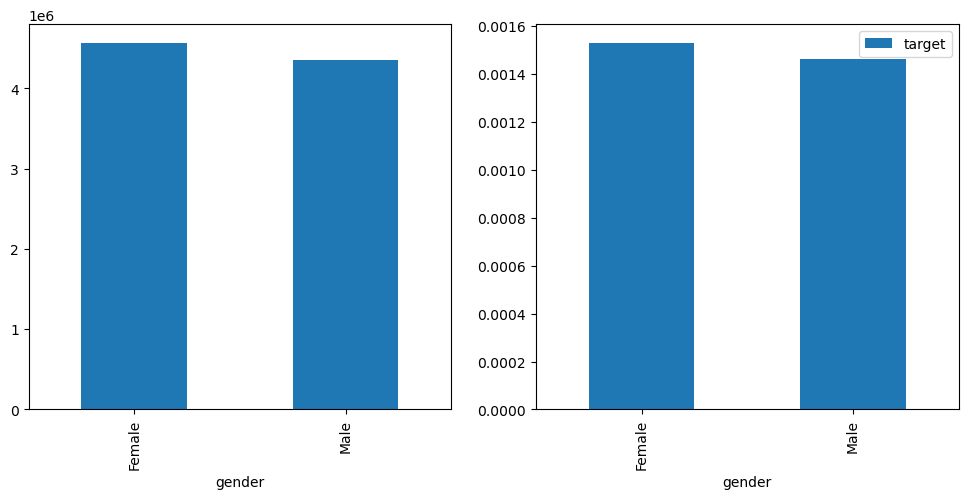

In [284]:
# gender와 target 비교
f, ax = plt.subplots(1, 2, figsize=(12, 5))
trans_df['gender'].value_counts().sort_index().plot.bar(ax=ax[0])
trans_df.groupby('gender').agg({'target': 'mean'}).plot.bar(ax=ax[1])
plt.show()

- 유의미한 차이 없음

In [285]:
# credit_score와 target
display(trans_df.loc[trans_df['target']==0, 'credit_score'].describe())
display(trans_df.loc[trans_df['target']==1, 'credit_score'].describe())

count    8.901631e+06
mean     7.139240e+02
std      6.581726e+01
min      4.880000e+02
25%      6.840000e+02
50%      7.160000e+02
75%      7.560000e+02
max      8.500000e+02
Name: credit_score, dtype: float64

count    13332.000000
mean       715.332283
std         64.203511
min        488.000000
25%        685.000000
50%        716.000000
75%        756.000000
max        850.000000
Name: credit_score, dtype: float64

- 분포 거의 비슷
- 유의미한 차이 없음

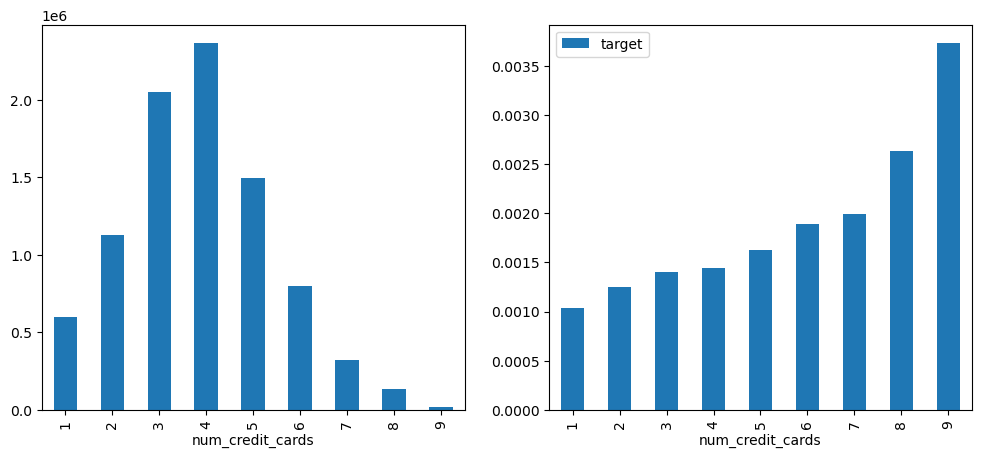

In [286]:
# num_credit_cards와 target
f, ax = plt.subplots(1, 2, figsize=(12, 5))
trans_df['num_credit_cards'].value_counts().sort_index().plot.bar(ax=ax[0])
trans_df.groupby('num_credit_cards').agg({'target': 'mean'}).plot.bar(ax=ax[1])
plt.show()

- 신용카드 수 많을수록 사기거래 비율이 높음

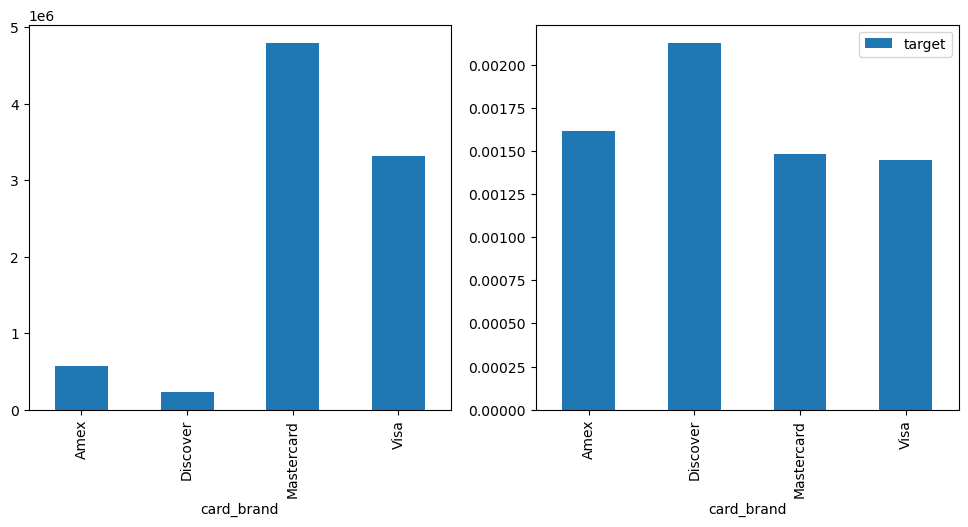

In [287]:
# card_brand와 target
f, ax = plt.subplots(1, 2, figsize=(12, 5))
trans_df['card_brand'].value_counts().sort_index().plot.bar(ax=ax[0])
trans_df.groupby('card_brand').agg({'target': 'mean'}).plot.bar(ax=ax[1])
plt.show()

- discover 제외하곤 비슷
- discover는 데이터 수가 가장 적지만 비율은 가장 높음

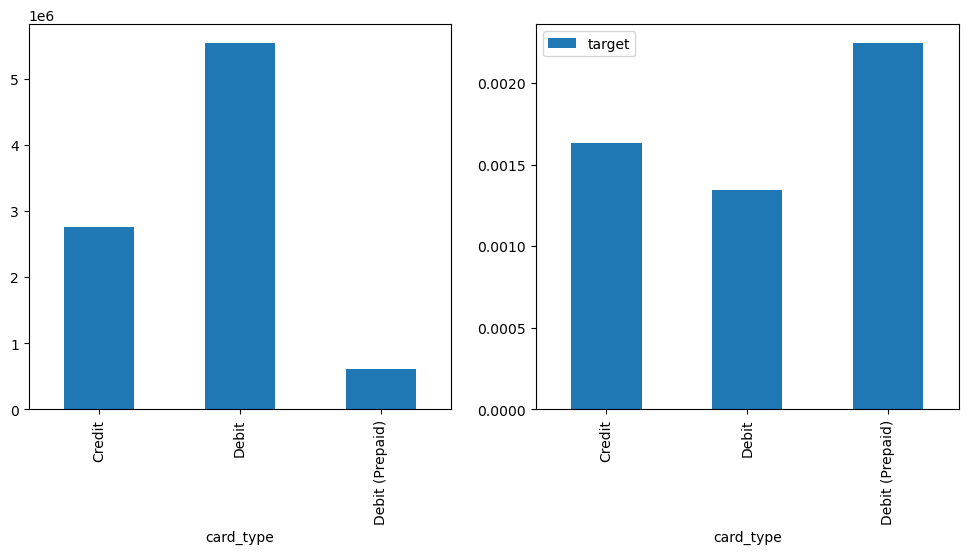

In [290]:
# card_type과 target
f, ax = plt.subplots(1, 2, figsize=(12, 5))
trans_df['card_type'].value_counts().sort_index().plot.bar(ax=ax[0])
trans_df.groupby('card_type').agg({'target': 'mean'}).plot.bar(ax=ax[1])
plt.show()

- 선불카드의 경우 사기거래 비율이 높으나, 큰 차이는 없어보임

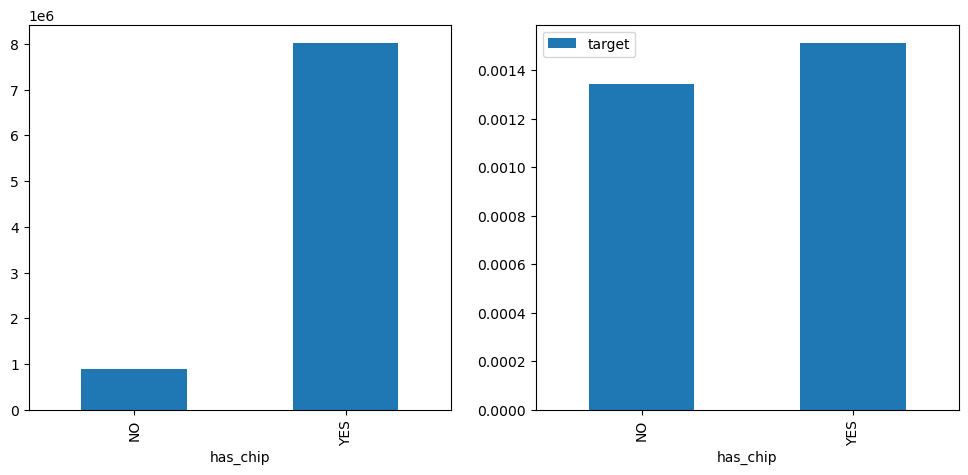

In [289]:
# has_chip과 target
f, ax = plt.subplots(1, 2, figsize=(12, 5))
trans_df['has_chip'].value_counts().sort_index().plot.bar(ax=ax[0])
trans_df.groupby('has_chip').agg({'target': 'mean'}).plot.bar(ax=ax[1])
plt.show()

- 유의미한 차이 없음

In [296]:
trans_df['yearly_income'] = pd.to_numeric(trans_df['yearly_income'].str.split('$', expand=True)[1])

In [297]:
trans_df['yearly_income'].describe()

count    8.914963e+06
mean     4.669135e+04
std      2.445588e+04
min      1.000000e+00
25%      3.281700e+04
50%      4.109100e+04
75%      5.401300e+04
max      2.801990e+05
Name: yearly_income, dtype: float64

- 연봉이 1 => 소득이 없는 상태이거나 이상치?

In [308]:
trans_df['yi_cat'] = pd.qcut(trans_df['yearly_income'], q=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

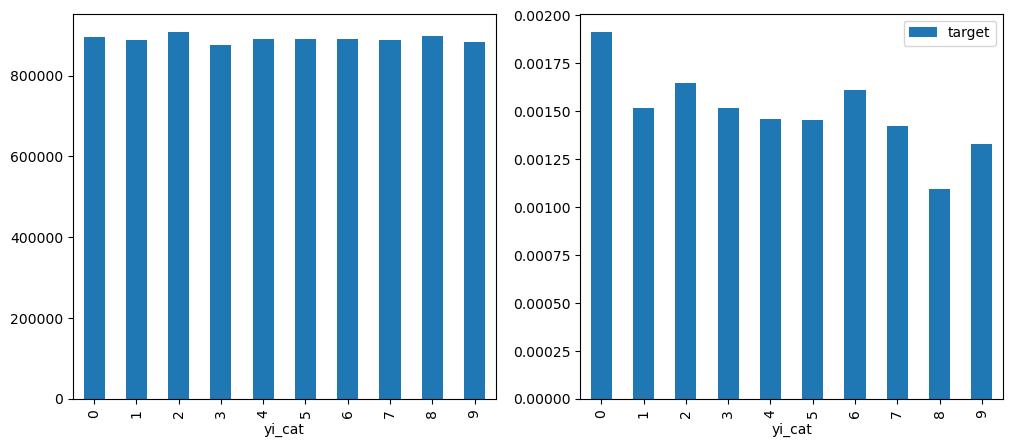

In [317]:
# yearly_income 과 target
f, ax = plt.subplots(1, 2, figsize=(12, 5))
trans_df['yi_cat'].value_counts().sort_index().plot.bar(ax=ax[0])
trans_df.groupby('yi_cat').agg({'target': 'mean'}).plot.bar(ax=ax[1])
plt.show()

- 연봉과 사기거래도 유의미한 관계 없어보임